In [1]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import h5py
from tqdm.notebook import tqdm
import torchcde
from scipy.signal import find_peaks
import MulensModel as mm
import corner
from model.utils import inference, get_loglik, get_peak_pred, plot_params, simulate_lc, infer_lgfs
from matplotlib.offsetbox import AnchoredText

torch.random.manual_seed(42)
np.random.seed(42)
plt.rcParams["font.family"] = "serif"
plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams['mathtext.rm'] = 'serif'

In [2]:
with h5py.File('/work/hmzhao/irregular-lc/KMT-fixrho-test.h5', mode='r') as dataset_file:
    Y = torch.tensor(dataset_file['Y'][...])
    X = torch.tensor(dataset_file['X'][...])

# filter nan
nanind = torch.where(~torch.isnan(X[:, 0, 1]))[0]
Y = Y[nanind]
X = X[nanind]
nanind = torch.where(Y[:, 2]>0)[0]
Y = Y[nanind]
X = X[nanind]
nanind = torch.where(Y[:, 2]<1)[0]
Y = Y[nanind]
X = X[nanind]

Y[:, 3:6] = torch.log10(Y[:, 3:6])
Y[:, -1] = torch.log10(Y[:, -1])
Y[:, 6] = Y[:, 6] / 180
# Y = Y[:, 2:]
Y = Y[:, [2, 4, 5, 6, 7]]
print('Shape of Y: ', Y.shape)

X[:, :, 1] = (X[:, :, 1] - 14.5 - 2.5 * Y[:, [-1]]) / 0.2
print(f'normalized X mean: {torch.mean(X[:, :, 1])}\nX std: {torch.mean(torch.std(X[:, :, 1], axis=0))}')

X = X[:, :, :2]
    
# CDE interpolation with log_sig
depth = 3; window_length = 5
logsig = torchcde.logsig_windows(X, depth, window_length=window_length)
coeffs = torchcde.hermite_cubic_coefficients_with_backward_differences(logsig)

Shape of Y:  torch.Size([100000, 5])
normalized X mean: -1.1743464469848672
X std: 1.046597228312195


In [3]:
from model.cde_mdn import CDE_MDN

device = torch.device("cuda:2" if torch.cuda.is_available() else "cpu")

checkpt = torch.load('/work/hmzhao/experiments/cde_mdn/experiment_l32nG12diag.ckpt', map_location='cpu')
ckpt_args = checkpt['args']
state_dict = checkpt['state_dict']

output_dim = Y.shape[-1]
input_dim = logsig.shape[-1]
latent_dim = ckpt_args.latents

model = CDE_MDN(input_dim, latent_dim, output_dim).to(device)
# model = CDE_MDN(input_dim, latent_dim, output_dim, 32).to(device)
model_dict = model.state_dict()

# 1. filter out unnecessary keys
state_dict = {k: v for k, v in state_dict.items() if k in model_dict}
# 2. overwrite entries in the existing state dict
model_dict.update(state_dict) 
# 3. load the new state dict
model.load_state_dict(state_dict)
model.to(device)

CDE_MDN(
  (cde_func): CDEFunc(
    (linear1): Linear(in_features=32, out_features=1024, bias=True)
    (relu1): PReLU(num_parameters=1)
    (resblocks): Sequential(
      (0): ResBlock(
        (linear1): Linear(in_features=1024, out_features=1024, bias=True)
        (nonlinear1): PReLU(num_parameters=1)
        (linear2): Linear(in_features=1024, out_features=1024, bias=True)
      )
      (1): ResBlock(
        (linear1): Linear(in_features=1024, out_features=1024, bias=True)
        (nonlinear1): PReLU(num_parameters=1)
        (linear2): Linear(in_features=1024, out_features=1024, bias=True)
      )
      (2): ResBlock(
        (linear1): Linear(in_features=1024, out_features=1024, bias=True)
        (nonlinear1): PReLU(num_parameters=1)
        (linear2): Linear(in_features=1024, out_features=1024, bias=True)
      )
    )
    (relu2): PReLU(num_parameters=1)
    (linear2): Linear(in_features=1024, out_features=160, bias=True)
    (tanh): Tanh()
    (linear3): Linear(in_features=

In [4]:
size = 4096 * 4

In [9]:
pis, locs, scales = inference(model, size, min(4096, size), coeffs, device, full_cov=False)

  0%|          | 0/4 [00:00<?, ?it/s]

In [10]:
pred_global, pred_global_loglik, pred_close, pred_close_loglik = get_peak_pred(pis, locs, scales, Y, n_step=1000)

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/16384 [00:00<?, ?it/s]

  0%|          | 0/16384 [00:00<?, ?it/s]

  0%|          | 0/16384 [00:00<?, ?it/s]

  0%|          | 0/16384 [00:00<?, ?it/s]

  0%|          | 0/16384 [00:00<?, ?it/s]

mse of log10q global:  0.07742165326243258
mse of log10q close:  0.03492782205891751
constraint 0.99359130859375
correct 0.8918852509367897
mse of log10s global:  0.014239363349828704
mse of log10s close:  0.0017259368330823544
constraint 0.98822021484375
correct 0.8573281452658884
mse of u0:  0.011194381217355113
mse of u0:  0.0038643013368639097
constraint 0.99078369140625
correct 0.8942278075525165
mse of alpha global:  6529.827202635362
mse of alpha close:  243.4526783686493
constraint 0.98846435546875
correct 0.7473911701142328
mse of log10fs global:  0.0036726450228301
mse of log10fs close:  0.002465846062495006


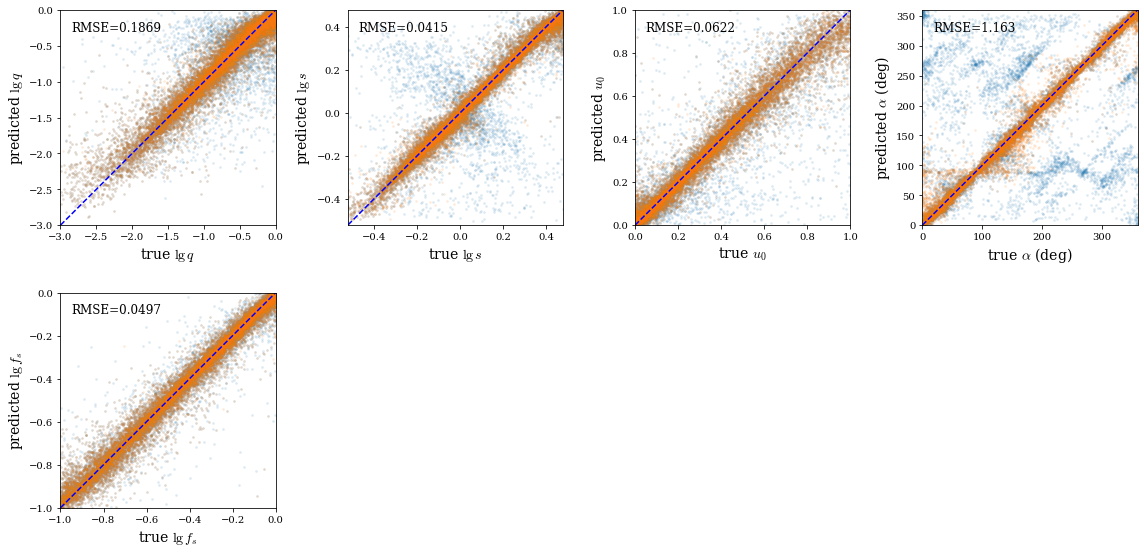

In [11]:
rmse = plot_params(size, Y, pred_global, pred_global_loglik, pred_close, pred_close_loglik, title=None)

In [9]:
n_points_list = [400, 300, 200, 100]
mse_global = np.zeros((len(n_points_list), output_dim))
mse_close = np.zeros((len(n_points_list), output_dim))
loglik_global = np.zeros((len(n_points_list), output_dim))
loglik_close = np.zeros((len(n_points_list), output_dim))
for i in tqdm(range(len(n_points_list))):
    n_points = n_points_list[i]
    subsample_ind = torch.argsort(torch.rand_like(X[:, :, 0]), dim=1)[:, :n_points]
    X_sub = X[torch.arange(X.shape[0]).unsqueeze(-1), subsample_ind]
    order = np.argsort(X_sub[:, :, 0].numpy(), axis=1)
    X_sub = X_sub[torch.arange(X_sub.shape[0]).unsqueeze(-1), order]

    # CDE interpolation with log_sig
    depth = 3; window_length = max(n_points//100, 1)
    logsig = torchcde.logsig_windows(X_sub, depth, window_length=window_length)
    coeffs = torchcde.hermite_cubic_coefficients_with_backward_differences(logsig)

    pis, locs, scales = inference(model, size, 4096, coeffs, device)
    pred_sub = get_peak_pred(pis, locs, scales, Y)

    mse_global[i] = torch.mean((pred_sub[0] - Y[:size])**2, dim=0).numpy()
    mse_close[i] = torch.mean((pred_sub[2] - Y[:size])**2, dim=0).numpy()
    loglik_global[i] = torch.mean(pred_sub[1], dim=0).numpy()
    loglik_close[i] = torch.mean(pred_sub[3], dim=0).numpy()

np.save('./mse_sub.npy', mse_close)

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/16384 [00:00<?, ?it/s]

  0%|          | 0/16384 [00:00<?, ?it/s]

  0%|          | 0/16384 [00:00<?, ?it/s]

  0%|          | 0/16384 [00:00<?, ?it/s]

  0%|          | 0/16384 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/16384 [00:00<?, ?it/s]

  0%|          | 0/16384 [00:00<?, ?it/s]

  0%|          | 0/16384 [00:00<?, ?it/s]

  0%|          | 0/16384 [00:00<?, ?it/s]

  0%|          | 0/16384 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/16384 [00:00<?, ?it/s]

  0%|          | 0/16384 [00:00<?, ?it/s]

  0%|          | 0/16384 [00:00<?, ?it/s]

  0%|          | 0/16384 [00:00<?, ?it/s]

  0%|          | 0/16384 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/16384 [00:00<?, ?it/s]

  0%|          | 0/16384 [00:00<?, ?it/s]

  0%|          | 0/16384 [00:00<?, ?it/s]

  0%|          | 0/16384 [00:00<?, ?it/s]

  0%|          | 0/16384 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/16384 [00:00<?, ?it/s]

  0%|          | 0/16384 [00:00<?, ?it/s]

  0%|          | 0/16384 [00:00<?, ?it/s]

  0%|          | 0/16384 [00:00<?, ?it/s]

  0%|          | 0/16384 [00:00<?, ?it/s]

mse of log10q global:  0.07742165326243258
mse of log10q close:  0.03492782205891751
constraint 0.99359130859375
correct 0.8918852509367897
mse of log10s global:  0.014239363349828704
mse of log10s close:  0.0017259368330823544
constraint 0.98822021484375
correct 0.8573281452658884
mse of u0:  0.011194381217355113
mse of u0:  0.0038643013368639097
constraint 0.99078369140625
correct 0.8942278075525165
mse of alpha global:  6529.827202635362
mse of alpha close:  243.4526783686493
constraint 0.98846435546875
correct 0.7473911701142328
mse of log10fs global:  0.0036726450228301
mse of log10fs close:  0.002465846062495006


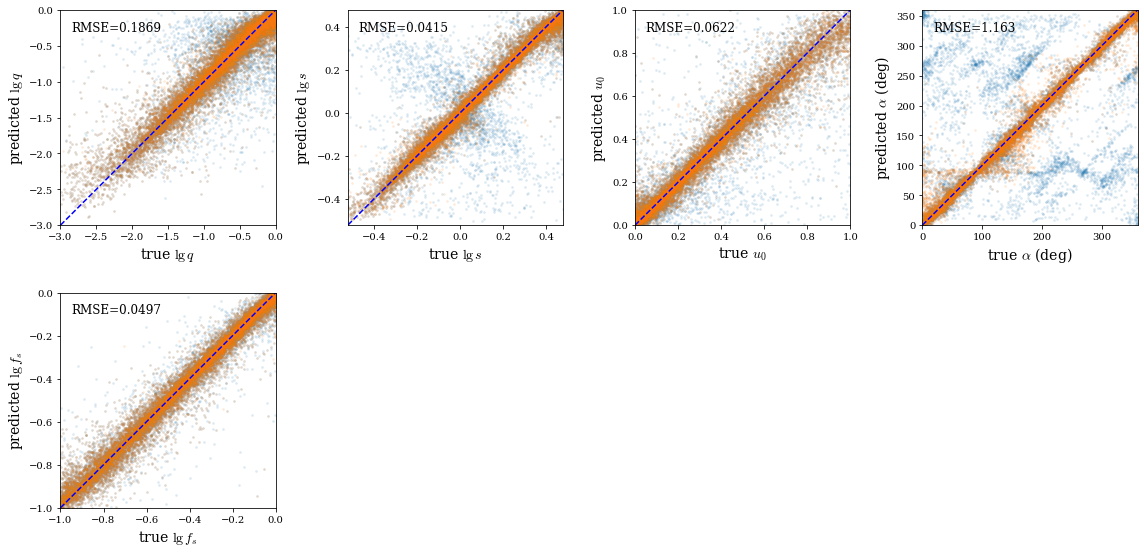

In [5]:
X_gap = torch.tensor(np.load('/work/hmzhao/X_gap.npy'))

# CDE interpolation with log_sig
depth = 3; window_length = max(X_gap.shape[1]//100, 1)
logsig = torchcde.logsig_windows(X_gap, depth, window_length=window_length)
coeffs = torchcde.hermite_cubic_coefficients_with_backward_differences(logsig)

pis_gap, locs_gap, scales_gap = inference(model, size, 4096, coeffs, device, full_cov=False)

pred_gap = get_peak_pred(pis_gap, locs_gap, scales_gap, Y)

rmse_gap = plot_params(size, Y, *pred_gap, title=None)

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/16384 [00:00<?, ?it/s]

  0%|          | 0/16384 [00:00<?, ?it/s]

  0%|          | 0/16384 [00:00<?, ?it/s]

  0%|          | 0/16384 [00:00<?, ?it/s]

  0%|          | 0/16384 [00:00<?, ?it/s]

mse of log10q global:  0.05687363955809601
mse of log10q close:  0.026381707885790407
constraint 0.99371337890625
correct 0.9098335483078435
mse of log10s global:  0.011291401060379236
mse of log10s close:  0.0013241127924335887
constraint 0.9898681640625
correct 0.8869157725983475
mse of u0:  0.00928433338392265
mse of u0:  0.003278275913464434
constraint 0.9920654296875
correct 0.907099790820721
mse of alpha global:  5621.943032957591
mse of alpha close:  227.23415082762082
constraint 0.98681640625
correct 0.779750123701138
mse of log10fs global:  0.0028608480187683745
mse of log10fs close:  0.001887332680840009


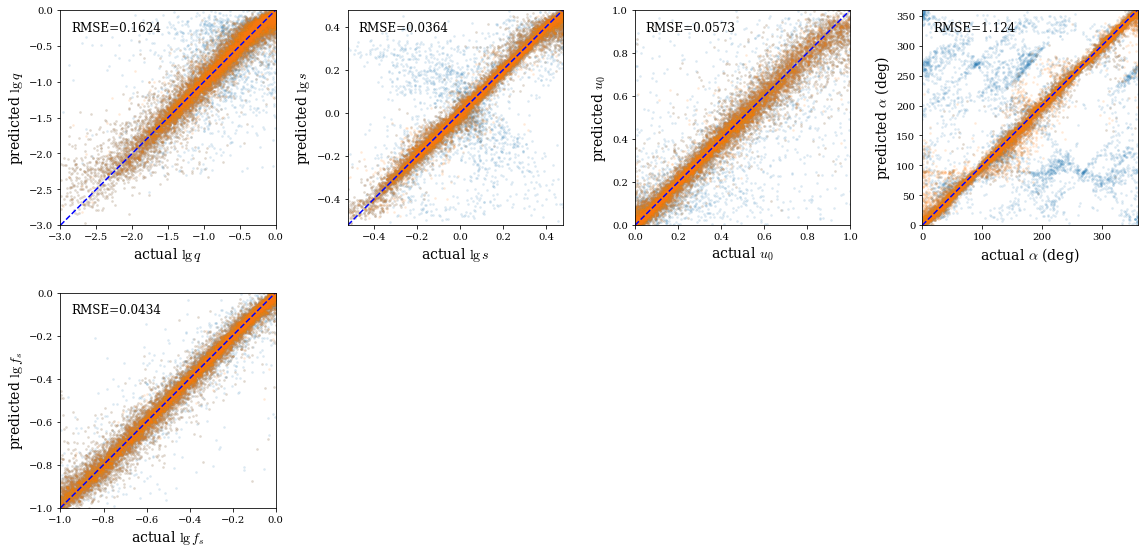

In [12]:
X_even = np.load('/work/hmzhao/KMT-fixrho-even.npy')
X_even = torch.tensor(X_even)

# CDE interpolation with log_sig
depth = 3; window_length = max(X_even.shape[1]//100, 1)
logsig = torchcde.logsig_windows(X_even, depth, window_length=window_length)
coeffs = torchcde.hermite_cubic_coefficients_with_backward_differences(logsig)

pis, locs, scales = inference(model, size, 4096, coeffs, device, full_cov=False)

pred_even = get_peak_pred(pis, locs, scales, Y)

rmse_even = plot_params(size, Y, *pred_even, title=None)

In [14]:
mse_close

array([[0.00377349, 0.03399402, 0.00169521, 0.00741093, 0.00220965],
       [0.00422219, 0.0394059 , 0.00194751, 0.00772978, 0.00267407],
       [0.0048766 , 0.05118116, 0.0024343 , 0.00814764, 0.00330616],
       [0.00762386, 0.10504442, 0.00464713, 0.00992826, 0.00553802]])

In [ ]:
mse_close = np.load('./mse_sub.npy')
rmse_sub = np.sqrt(mse_close[:, [1, 2, 0, 3, 4]]).T

fig = plt.figure(figsize=(6, 6))
width = 0.1
labels = [r'$\lg q$', r'$\lg s$', r'$u_0$', r'$\alpha$', r'$\lg f_s$']
cats = ['500\nregular', 'irregular', 'gapped', '400', '300', '200', '100']
markers = ['o', 's', '^', '+', 'x']
rmses = np.stack([rmse_even, rmse, rmse_gap], axis=-1)
rmses = np.hstack([rmses, rmse_sub])
rmses = rmses / rmses[:, [0]]
left = 1; right = None
for i, label in enumerate(labels):
    plt.bar(np.arange(len(cats[left:right]))+(i-2)*width, rmses[i, left:right]-1, width, label=label)
    # plt.plot(cats[left:right], rmses[i, left:right]-1, linestyle='dashed')
plt.ylabel(r'$\Delta$ RMSE / RMSE_regular', fontsize=14)
plt.ylim(bottom=0)
plt.xticks(np.arange(len(cats[left:right])), cats[left:right], fontsize=14)
plt.yticks(np.arange(0, 1.1, 0.1), fontsize=14)
plt.legend()
plt.tight_layout()
plt.savefig('./rmse.pdf')
plt.show()

In [15]:
def plot_params_new(num, Y, pred_global, pred_global_loglik, pred_close, pred_close_loglik, 
                title=None, figsize=(16, 8), labelsize=14, alpha=0.1, save=None,
                example_groundtruth=np.ones(5)*np.inf, example_pred=np.ones(5)*np.inf, rmse_plot=False, rmse_ir=False):
    rmse = []

    fig = plt.figure(figsize=figsize)
    axq = plt.subplot2grid(shape=(2, 3), loc=(0, 0), rowspan=1, colspan=1)
    axq.axis('square')
    axq.set_xlim(-3, 0)
    axq.set_ylim(-3, 0)
    axq.set_xlabel(r'true $\lg q$', fontsize=labelsize)
    axq.set_ylabel(r'predicted $\lg q$', fontsize=labelsize)
    axq.scatter(Y[:num, 1], pred_global.numpy()[:num, 1], s=3, cmap='Blues', label='global', alpha=alpha, rasterized=True)
    axq.scatter(Y[:num, 1], pred_close.numpy()[:num, 1], s=3, cmap='Oranges', label='close', alpha=alpha, rasterized=True)
    axq.scatter(example_groundtruth[1], example_pred[1], s=100, color='black', marker='*')
    axq.plot(np.linspace(-3, 0), np.linspace(-3, 0), color='b', linestyle='dashed')
    # axq.legend(loc='lower right')
    print('mse of log10q global: ', torch.mean((Y[:num, 1] -  pred_global.numpy()[:num, 1])**2).detach().cpu().item())
    print('mse of log10q close: ', torch.mean((Y[:num, 1] -  pred_close.numpy()[:num, 1])**2).detach().cpu().item())
    constraint_ind = pred_global_loglik[:num, 1]>np.log(2*1/3)
    print('constraint', torch.sum(constraint_ind).item()/num)
    print('correct', torch.sum(pred_global[:num, 1][constraint_ind]==pred_close[:num, 1][constraint_ind]).item()/torch.sum(constraint_ind).item())
    at = AnchoredText(
        "RMSE=%.4f" % (np.sqrt(torch.mean((Y[:num, 1] -  pred_close.numpy()[:num, 1])**2).detach().cpu().item())), prop=dict(size=12), frameon=False, loc='upper left')
    axq.add_artist(at)
    rmse.append(np.sqrt(torch.mean((Y[:num, 1] -  pred_close.numpy()[:num, 1])**2).detach().cpu().item()))
    
    axs = plt.subplot2grid(shape=(2, 3), loc=(0, 1), rowspan=1, colspan=1)
    axs.axis('square')
    axs.set_xlim(np.log10(0.3), np.log10(3))
    axs.set_ylim(np.log10(0.3), np.log10(3))
    axs.set_xlabel(r'true $\lg s$', fontsize=labelsize)
    axs.set_ylabel(r'predicted $\lg s$', fontsize=labelsize)
    axs.scatter(Y[:num, 2], pred_global.numpy()[:num, 2], s=3, cmap='Blues', label='global', alpha=alpha, rasterized=True)
    axs.scatter(Y[:num, 2], pred_close.numpy()[:num, 2], s=3, cmap='Oranges', label='close', alpha=alpha, rasterized=True)
    axs.scatter(example_groundtruth[2], example_pred[2], s=100, color='black', marker='*')
    axs.plot(np.linspace(-0.6, 0.6), np.linspace(-0.6, 0.6), color='b', linestyle='dashed')
    # axs.legend(loc='lower right')
    print('mse of log10s global: ', torch.mean((Y[:num, 2] -  pred_global.numpy()[:num, 2])**2).detach().cpu().item())
    print('mse of log10s close: ', torch.mean((Y[:num, 2] -  pred_close.numpy()[:num, 2])**2).detach().cpu().item())
    constraint_ind = pred_global_loglik[:num, 2]>np.log(2*1/2/np.log10(3))
    print('constraint', torch.sum(constraint_ind).item()/num)
    print('correct', torch.sum(pred_global[:num, 2][constraint_ind]==pred_close[:num, 2][constraint_ind]).item()/torch.sum(constraint_ind).item())
    at = AnchoredText(
        "RMSE=%.4f" % (np.sqrt(torch.mean((Y[:num, 2] -  pred_close.numpy()[:num, 2])**2).detach().cpu().item())), prop=dict(size=12), frameon=False, loc='upper left')
    axs.add_artist(at)
    rmse.append(np.sqrt(torch.mean((Y[:num, 2] -  pred_close.numpy()[:num, 2])**2).detach().cpu().item()))

    axu = plt.subplot2grid(shape=(2, 3), loc=(0, 2), rowspan=1, colspan=1)
    axu.axis('square')
    axu.set_xlim(0, 1)
    axu.set_ylim(0, 1)
    axu.set_xlabel(r'true $u_0$', fontsize=labelsize)
    axu.set_ylabel(r'predicted $u_0$', fontsize=labelsize)
    axu.scatter(Y[:num, 0], pred_global.numpy()[:num, 0], s=3, cmap='Blues', label='global', alpha=alpha, rasterized=True)
    axu.scatter(Y[:num, 0], pred_close.numpy()[:num, 0], s=3, cmap='Oranges', label='close', alpha=alpha, rasterized=True)
    axu.scatter(example_groundtruth[0], example_pred[0], s=100, color='black', marker='*')
    axu.plot(np.linspace(0, 1), np.linspace(0, 1), color='b', linestyle='dashed')
    # axu.legend(loc='lower right')
    print('mse of u0: ', torch.mean((Y[:num, 0] -  pred_global.numpy()[:num, 0])**2).detach().cpu().item())
    print('mse of u0: ', torch.mean((Y[:num, 0] -  pred_close.numpy()[:num, 0])**2).detach().cpu().item())
    constraint_ind = pred_global_loglik[:num, 0]>np.log(2*1/1)
    print('constraint', torch.sum(constraint_ind).item()/num)
    print('correct', torch.sum(pred_global[:num, 0][constraint_ind]==pred_close[:num, 0][constraint_ind]).item()/torch.sum(constraint_ind).item())
    at = AnchoredText(
        "RMSE=%.4f" % (np.sqrt(torch.mean((Y[:num, 0] -  pred_close.numpy()[:num, 0])**2).detach().cpu().item())), prop=dict(size=12), frameon=False, loc='upper left')
    axu.add_artist(at)
    rmse.append(np.sqrt(torch.mean((Y[:num, 0] -  pred_close.numpy()[:num, 0])**2).detach().cpu().item()))

    axa = plt.subplot2grid(shape=(2, 3), loc=(1, 0), rowspan=1, colspan=1)
    axa.axis('square')
    axa.set_xlim(0, 360)
    axa.set_ylim(0, 360)
    axa.set_xlabel(r'true $\alpha$ (deg)', fontsize=labelsize)
    axa.set_ylabel(r'predicted $\alpha$ (deg)', fontsize=labelsize)
    axa.scatter(Y[:num, 3]*180, pred_global.numpy()[:num, 3]*180, s=3, cmap='Blues', label='global', alpha=alpha, rasterized=True)
    axa.scatter(Y[:num, 3]*180, pred_close.numpy()[:num, 3]*180, s=3, cmap='Oranges', label='close', alpha=alpha, rasterized=True)
    axa.scatter(example_groundtruth[3]*180, example_pred[3]*180, s=100, color='black', marker='*')
    axa.plot(np.linspace(0, 360), np.linspace(0, 360), color='b', linestyle='dashed')
    # axa.legend(loc='lower right')
    print('mse of alpha global: ', torch.mean((Y[:num, 3]*180 -  pred_global.numpy()[:num, 3]*180)**2).detach().cpu().item())
    print('mse of alpha close: ', torch.mean((Y[:num, 3]*180 -  pred_close.numpy()[:num, 3]*180)**2).detach().cpu().item())
    constraint_ind = pred_global_loglik[:num, 3]>np.log(2*1/2)
    print('constraint', torch.sum(constraint_ind).item()/num)
    print('correct', torch.sum(pred_global[:num, 3][constraint_ind]==pred_close[:num, 3][constraint_ind]).item()/torch.sum(constraint_ind).item())
    at = AnchoredText(
        "RMSE=%.3f" % np.sqrt((torch.mean((Y[:num, 3] -  pred_close.numpy()[:num, 3])**2).detach().cpu().item())*180), prop=dict(size=12), frameon=False, loc='upper left')
    axa.add_artist(at)
    rmse.append(np.sqrt(torch.mean((Y[:num, 3] -  pred_close.numpy()[:num, 3])**2).detach().cpu().item()))

    axf = plt.subplot2grid(shape=(2, 3), loc=(1, 1), rowspan=1, colspan=1)
    axf.axis('square')
    axf.set_xlim(-1, 0)
    axf.set_ylim(-1, 0)
    axf.set_xlabel(r'true $\lg f_s$', fontsize=labelsize)
    axf.set_ylabel(r'predicted $\lg f_s$', fontsize=labelsize)
    axf.scatter(Y[:num, 4], pred_global.numpy()[:num, 4], s=3, cmap='Blues', label='global', alpha=alpha, rasterized=True)
    axf.scatter(Y[:num, 4], pred_close.numpy()[:num, 4], s=3, cmap='Oranges', label='close', alpha=alpha, rasterized=True)
    axf.scatter(example_groundtruth[4], example_pred[4], s=100, color='black', marker='*')
    axf.plot(np.linspace(-1, 0), np.linspace(-1, 0), color='b', linestyle='dashed')
    # axf.legend(loc='lower right')
    print('mse of log10fs global: ', torch.mean((Y[:num, 4] -  pred_global.numpy()[:num, 4])**2).detach().cpu().item())
    print('mse of log10fs close: ', torch.mean((Y[:num, 4] -  pred_close.numpy()[:num, 4])**2).detach().cpu().item())
    # constraint_ind = pred_global_loglik[:num, 4]>np.log(2*1/1)
    # print('constraint', torch.sum(constraint_ind).item()/num)
    # print('correct', torch.sum(pred_global[:num, 4][constraint_ind]==pred_close[:num, 4][constraint_ind]).item()/torch.sum(constraint_ind).item())
    at = AnchoredText(
        "RMSE=%.4f" % np.sqrt((torch.mean((Y[:num, 4] -  pred_close.numpy()[:num, 4])**2).detach().cpu().item())), prop=dict(size=12), frameon=False, loc='upper left')
    axf.add_artist(at)
    rmse.append(np.sqrt(torch.mean((Y[:num, 4] -  pred_close.numpy()[:num, 4])**2).detach().cpu().item()))

    if rmse_plot:
        mse_close = np.load('./mse_sub.npy')
        rmse_sub = np.sqrt(mse_close[:, [1, 2, 0, 3, 4]]).T

        ax_rmse = plt.subplot2grid(shape=(2, 3), loc=(1, 2), rowspan=1, colspan=1)
        ax_rmse.axis('square')
        ax_rmse.set_xlim(-0.1, 1.1)
        ax_rmse.set_ylim(0.9, 2.1)
        width = 0.1
        labels = [r'$\lg q$', r'$\lg s$', r'$u_0$', r'$\alpha$', r'$\lg f_s$']
        cats = ['500', '400', '300', '200', '100']
        # markers = ['o', 's', '^', '+', 'x']
        rmses = np.array(rmse_ir).reshape(-1, 1)
        rmses = np.hstack([rmses, rmse_sub])
        rmses = rmses / rmses[:, [0]]
        left = 1; right = None
        for i, label in enumerate(labels):
            # plt.bar((np.arange(len(cats[left:right]))+(i)*width)*2/10+0.05, rmses[i, left:right]-1, width*2/10, label=label)
            plt.plot((np.arange(len(cats[left:right])))/(len(cats[left:right])-1), rmses[i, left:right], label=label)
            plt.scatter((np.arange(len(cats[left:right])))/(len(cats[left:right])-1), rmses[i, left:right])
        plt.ylabel(r'RMSE / RMSE_500', fontsize=14)
        plt.xlabel('Number of points', fontsize=14)
        plt.xticks(np.arange(len(cats[left:right]))/(len(cats[left:right])-1), cats[left:right], fontsize=14)
        # plt.yticks(np.arange(0, 1.1, 0.1), fontsize=14)
        plt.legend()
    
    plt.tight_layout()
        
    if title != None:
        fig.suptitle(title)

    if save != None:
        plt.savefig(save)
    
    plt.show()
    return rmse

mse of log10q global:  0.07742165326243258
mse of log10q close:  0.03492782205891751
constraint 0.99359130859375
correct 0.8918852509367897
mse of log10s global:  0.014239363349828704
mse of log10s close:  0.0017259368330823544
constraint 0.98822021484375
correct 0.8573281452658884
mse of u0:  0.011194381217355113
mse of u0:  0.0038643013368639097
constraint 0.99078369140625
correct 0.8942278075525165
mse of alpha global:  6529.827202635362
mse of alpha close:  243.4526783686493
constraint 0.98846435546875
correct 0.7473911701142328
mse of log10fs global:  0.0036726450228301
mse of log10fs close:  0.002465846062495006


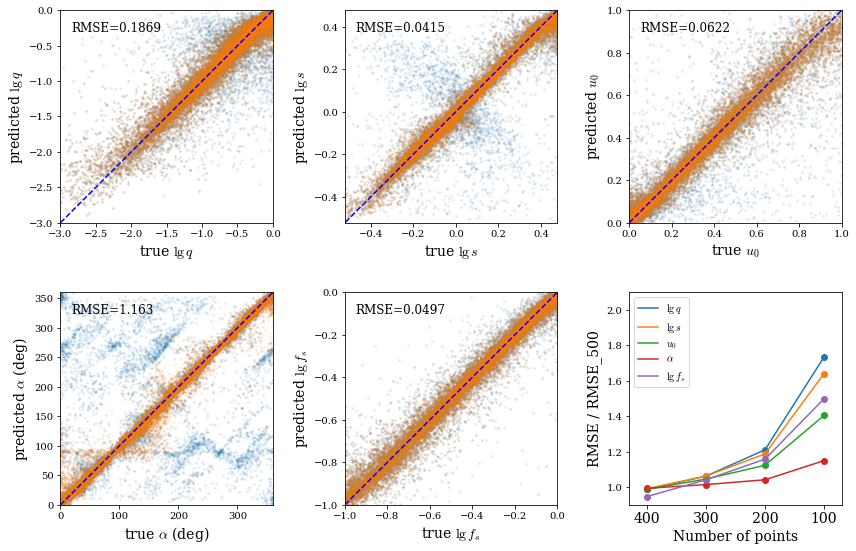

In [16]:
_ = plot_params_new(size, Y, *pred_gap, figsize=(12, 8), title=None, rmse_plot=True, rmse_ir=rmse, save='./params.pdf')